In [1]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import defaultdict

In [2]:
def parseData(fname):
    with gzip.open(fname, 'rt') as f:
        for l in f:
            yield eval(l)


allRatings = list(parseData("ratebeer.json.gz"))

# Convert to dataframe
data = pd.DataFrame(allRatings)

# Delete allRatings to free up memory
del allRatings

In [3]:
# print(type(allRatings[10]))
# allRatings[10]

In [4]:
# Read data from DF JSON
# data = pd.read_json('ratebeer_df.json.gz', compression='gzip', lines=True)

In [5]:
# EDA

In [6]:
# Step 1: Data Overview
# Check for missing values
missing_values = data.isnull().sum()

# Determine unique counts for key columns
unique_beers = data['beer/beerId'].nunique()
unique_breweries = data['beer/brewerId'].nunique()
unique_reviewers = data['review/profileName'].nunique()

# Display the results
print("Missing Values Per Column:\n", missing_values)
print("\nUnique Counts:")
print(f"Number of unique beers: {unique_beers}")
print(f"Number of unique breweries: {unique_breweries}")
print(f"Number of unique reviewers: {unique_reviewers}")

# Remove these empty entries
data = data.dropna()

Missing Values Per Column:
 beer/name             1
beer/beerId           1
beer/brewerId         1
beer/ABV              1
beer/style            1
review/appearance     1
review/aroma          1
review/palate         1
review/taste          1
review/overall        1
review/time           1
review/profileName    1
review/text           1
dtype: int64

Unique Counts:
Number of unique beers: 110369
Number of unique breweries: 7547
Number of unique reviewers: 29265


In [7]:
# Step 2: Summary Statistics

# Convert rating columns to numeric values if they are not already
rating_columns = ['review/appearance', 'review/aroma', 'review/palate', 'review/taste', 'review/overall']
for column in rating_columns:
    # data[column] = pd.to_numeric(data[column], errors='coerce')
    data[column] = data[column].apply(lambda x: float(x.split('/')[0]) / float(x.split('/')[1]))

# Compute summary statistics for numerical columns
numerical_summary = data[['beer/ABV', 'review/appearance', 'review/aroma', 
                          'review/palate', 'review/taste', 'review/overall']].describe()

# Display the summary statistics
print("\nSummary Statistics for Numerical Columns:\n", numerical_summary)


Summary Statistics for Numerical Columns:
        review/appearance  review/aroma  review/palate  review/taste  \
count       2.924163e+06  2.924163e+06   2.924163e+06  2.924163e+06   
mean        6.864054e-01  6.353608e-01   6.514471e-01  6.451929e-01   
std         1.625114e-01  1.639165e-01   1.659462e-01  1.622888e-01   
min         2.000000e-01  1.000000e-01   2.000000e-01  1.000000e-01   
25%         6.000000e-01  6.000000e-01   6.000000e-01  6.000000e-01   
50%         6.000000e-01  7.000000e-01   6.000000e-01  7.000000e-01   
75%         8.000000e-01  7.000000e-01   8.000000e-01  8.000000e-01   
max         1.000000e+00  1.000000e+00   1.000000e+00  1.000000e+00   

       review/overall  
count    2.924163e+06  
mean     6.599848e-01  
std      1.676290e-01  
min      5.000000e-02  
25%      6.000000e-01  
50%      7.000000e-01  
75%      7.500000e-01  
max      1.000000e+00  



Correlations Between Individual Ratings and Overall Rating:
 review/appearance    0.566359
review/aroma         0.789023
review/palate        0.700894
review/taste         0.876243
Name: review/overall, dtype: float64


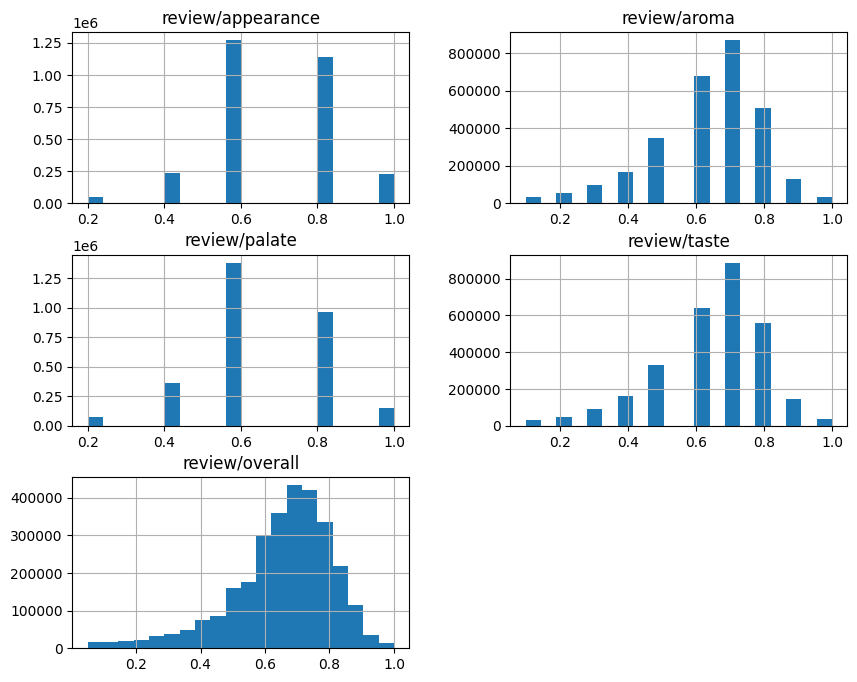

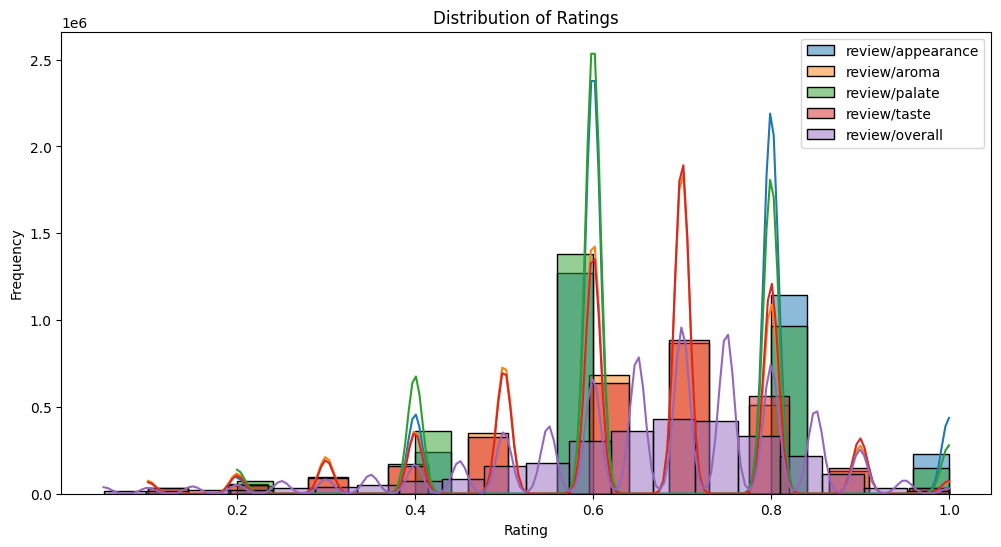

In [8]:
# Step 3: Ratings Analysis

# Analyze distributions of ratings
rating_distributions = data[rating_columns].hist(figsize=(10, 8), bins=20)

# Compute correlations between individual ratings and overall rating
correlations = data[rating_columns].corr()['review/overall'].drop('review/overall')

# Display the correlations
print("\nCorrelations Between Individual Ratings and Overall Rating:\n", correlations)

# Analyze rating distributions together
plt.figure(figsize=(12, 6))
for col in rating_columns:
    sns.histplot(data[col], bins=20, kde=True, label=col)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.show()

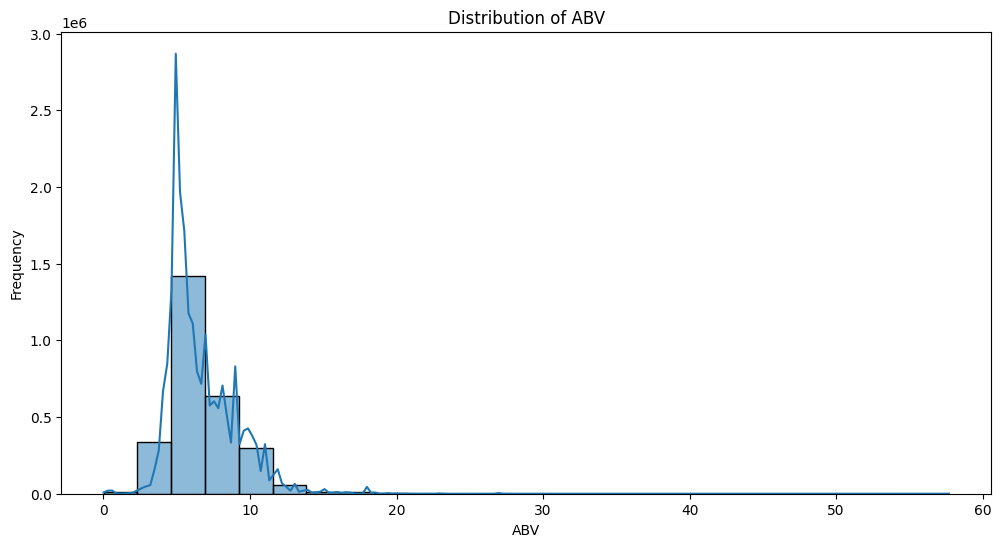

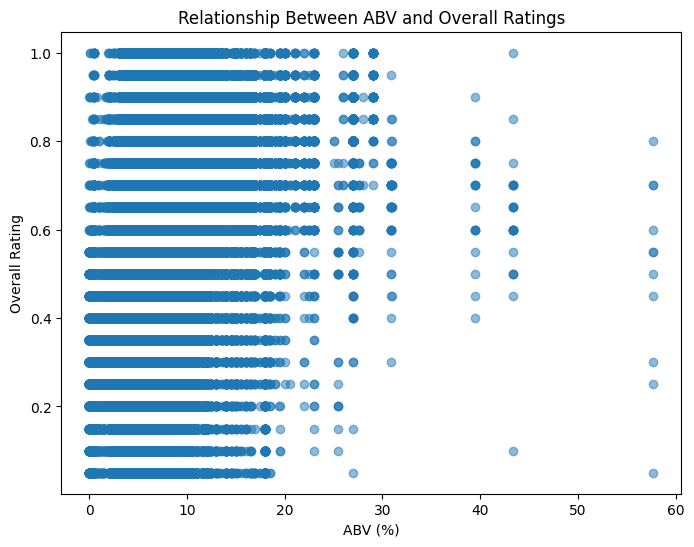


Most Common Beer Styles:
 beer/style
India Pale Ale &#40;IPA&#41;    185953
Pale Lager                      145618
Belgian Strong Ale              123946
Imperial Stout                  122223
Imperial/Double IPA             105672
Name: count, dtype: int64

Average Ratings by Beer Style:
 beer/style
Sak - Koshu            0.803448
Imperial Stout         0.792707
Ice Cider/Perry        0.790377
Abt/Quadrupel          0.783495
Imperial/Double IPA    0.772852
Name: review/overall, dtype: float64


In [9]:
data['beer/ABV'] = pd.to_numeric(data['beer/ABV'], errors='coerce')

# Step 4: Exploration by Category
# Most common beer styles and their average ratings
style_counts = data['beer/style'].value_counts()
style_avg_ratings = data.groupby('beer/style')['review/overall'].mean().sort_values(ascending=False)

# ABV analysis
plt.figure(figsize=(12, 6))
sns.histplot(data['beer/ABV'].dropna(), bins=25, kde=True)
plt.title('Distribution of ABV')
plt.xlabel('ABV')
plt.ylabel('Frequency')
plt.show()

# Relationship between ABV and overall ratings
plt.figure(figsize=(8, 6))
plt.scatter(data['beer/ABV'], data['review/overall'], alpha=0.5)
plt.title('Relationship Between ABV and Overall Ratings')
plt.xlabel('ABV (%)')
plt.ylabel('Overall Rating')
plt.show()

# Display the most common styles and their average ratings
print("\nMost Common Beer Styles:\n", style_counts.head())
print("\nAverage Ratings by Beer Style:\n", style_avg_ratings.head())

review/profileName
fonefan     16364
Ungstrup    15296
Papsoe      14170
yespr       13486
oh6gdx       9994
Name: count, dtype: int64
User Review Counts: count    29265.000000
mean        99.920144
std        465.198061
min          1.000000
25%          1.000000
50%          3.000000
75%         16.000000
max      16364.000000
Name: count, dtype: float64


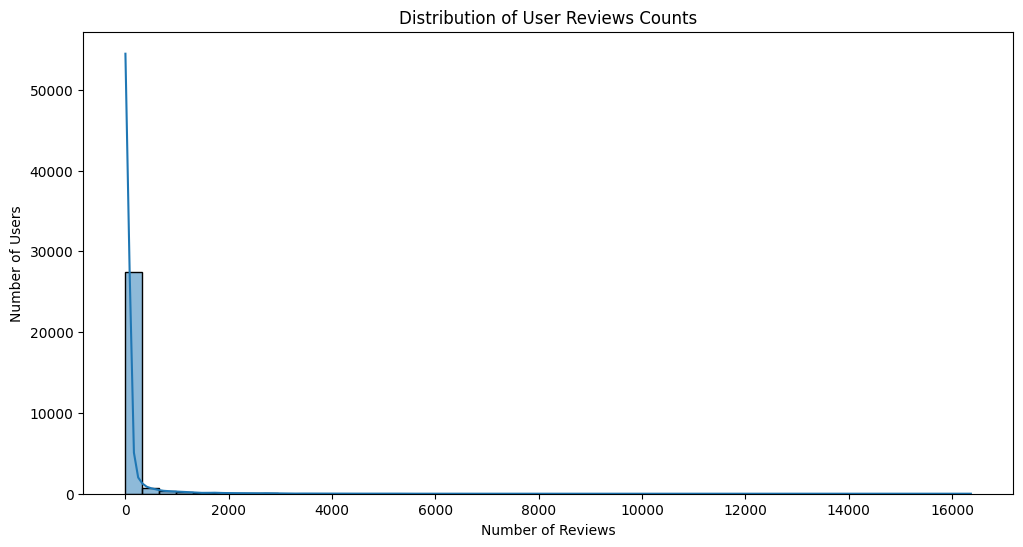

In [10]:
# User activity analysis
user_activity = data['review/profileName'].value_counts()
print(user_activity.head())

# User behavior analysis
user_review_counts = data['review/profileName'].value_counts()
print("User Review Counts:", user_review_counts.describe())

# User Activity (count) plot
plt.figure(figsize=(12, 6))
sns.histplot(user_review_counts.dropna(), bins=50, kde=True)
plt.title('Distribution of User Reviews Counts')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')
plt.show()

In [11]:
# Item popularity analysis
item_popularity = data['beer/name'].value_counts()
print(item_popularity.head())

beer/name
Guinness Draught                           3696
Pabst Blue Ribbon                          3662
Dogfish Head 90 Minute Imperial IPA        3230
Budweiser                                  3126
Sierra Nevada Pale Ale &#40;Bottle&#41;    3119
Name: count, dtype: int64


In [12]:
# Sparsity check
num_users = data['review/profileName'].nunique()
num_items = data['beer/name'].nunique()
sparsity = 1 - len(data) / (num_users * num_items)
print(f"Data sparsity: {sparsity:.2%}")

Data sparsity: 99.91%


/tmp/ipykernel_2760/490728897.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['review/time'] = pd.to_datetime(data['review/time'], unit='s')


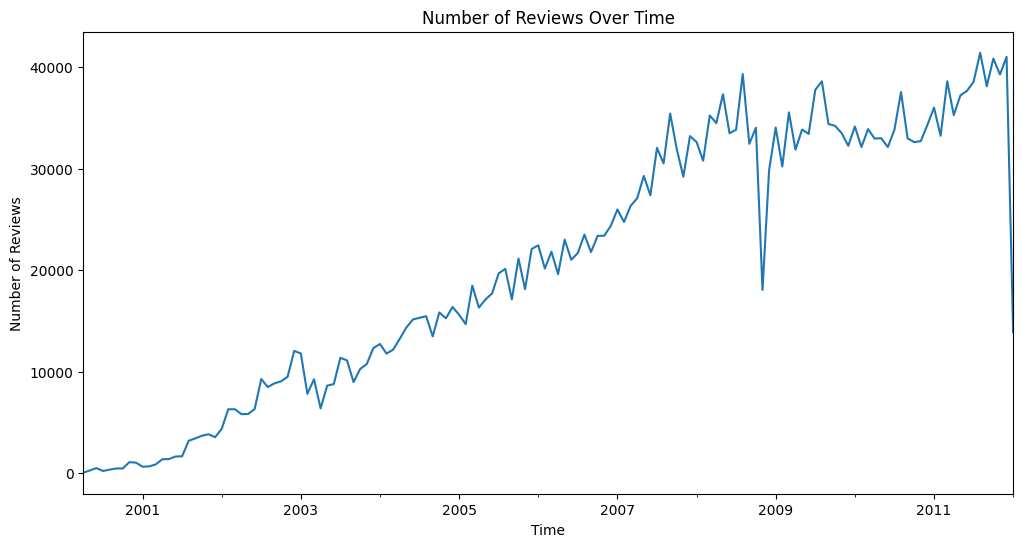

In [13]:
# Convert review time to datetime
data['review/time'] = pd.to_datetime(data['review/time'], unit='s')

# Temporal analysis
plt.figure(figsize=(12, 6))
data['review/time'].dt.to_period('M').value_counts().sort_index().plot()
plt.title('Number of Reviews Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Reviews')
plt.show()

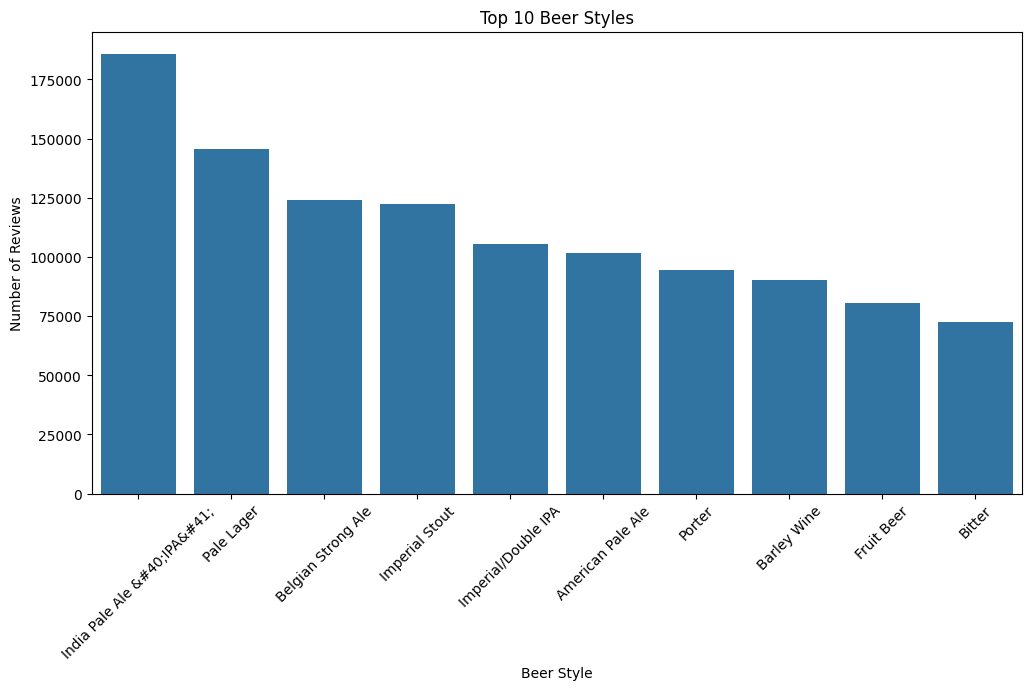

In [14]:
# Beer style analysis
top_styles = data['beer/style'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_styles.index, y=top_styles.values)
plt.xticks(rotation=45)
plt.title('Top 10 Beer Styles')
plt.xlabel('Beer Style')
plt.ylabel('Number of Reviews')
plt.show()

In [15]:
# Brewery analysis
top_breweries = data['beer/brewerId'].value_counts().head(10)
print("Top Breweries by Number of Reviews:", top_breweries)

Top Breweries by Number of Reviews: beer/brewerId
32      46566
76      38663
198     37364
96      35151
232     32433
84      32418
67      31823
15      25159
75      24573
7043    22841
Name: count, dtype: int64


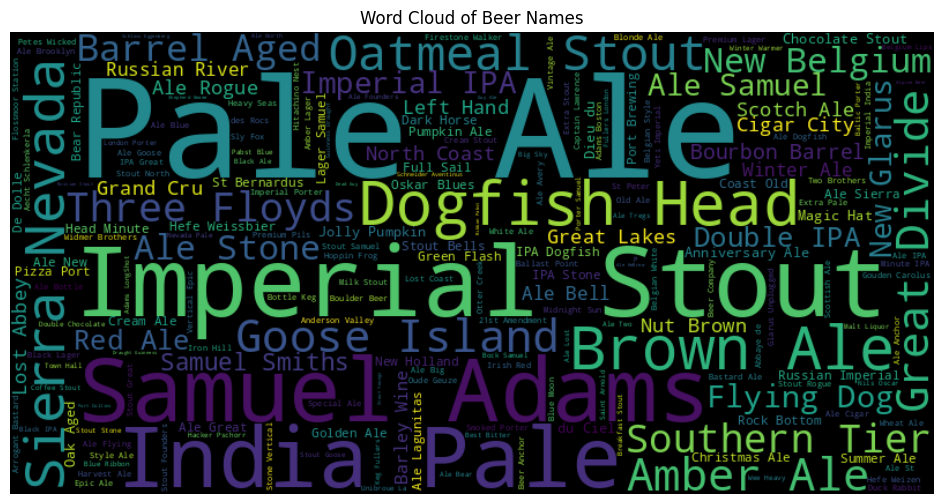

In [16]:
# Text analysis (Word Cloud for beer names)
text = ' '.join(data['beer/name'].astype(str))
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Beer Names')
plt.show()

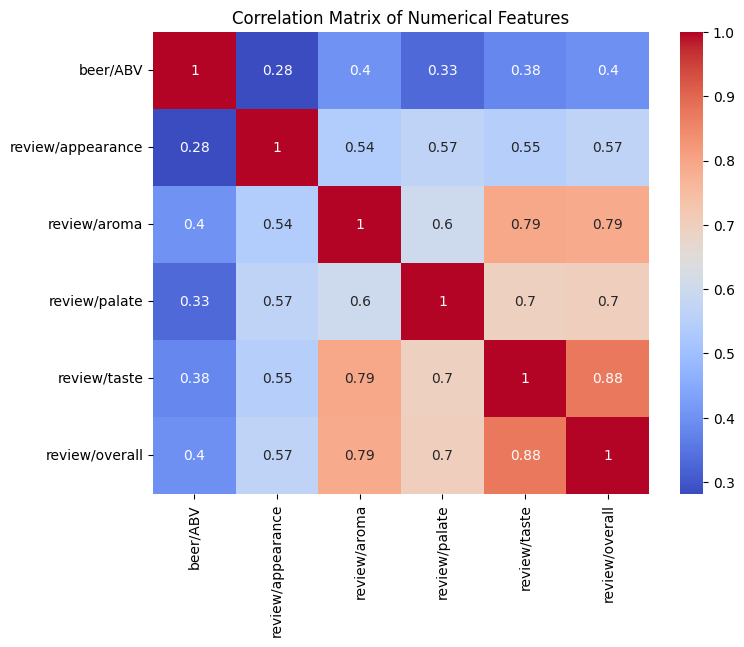

In [17]:
# Correlation analysis
corr = data[['beer/ABV'] + rating_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [18]:
# beer_styles = list(data['beer/style'].unique())
beer_styles_dist = data['beer/style'].value_counts(normalize=True)
data['beer/style_dist'] = data['beer/style'].map(beer_styles_dist)
data['beer/style_dist']

0          0.063592
1          0.063592
2          0.005977
3          0.005985
4          0.005985
             ...   
2924158    0.022668
2924159    0.023576
2924160    0.023576
2924161    0.023576
2924162    0.023576
Name: beer/style_dist, Length: 2924163, dtype: float64

In [19]:
data['beer/style_dist_wt'] = data['beer/style'].map(beer_styles_dist) * data['beer/style'].map(style_avg_ratings)
data['beer/style_dist_wt']

0          0.045573
1          0.045573
2          0.003725
3          0.003544
4          0.003544
             ...   
2924158    0.016141
2924159    0.015331
2924160    0.015331
2924161    0.015331
2924162    0.015331
Name: beer/style_dist_wt, Length: 2924163, dtype: float64

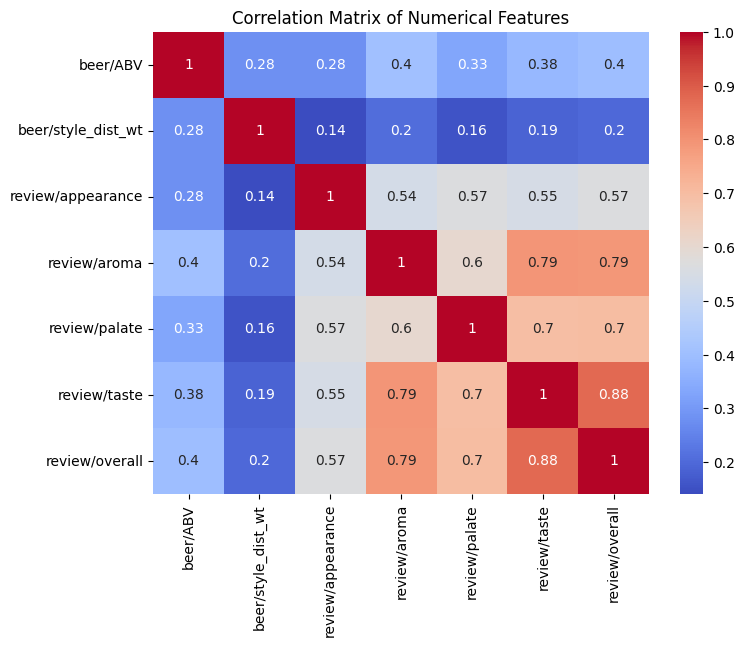

In [20]:
# New Correlation analysis
corr = data[['beer/ABV'] + ['beer/style_dist_wt'] + rating_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [21]:
style_avg_ratings

beer/style
Sak - Koshu            0.803448
Imperial Stout         0.792707
Ice Cider/Perry        0.790377
Abt/Quadrupel          0.783495
Imperial/Double IPA    0.772852
                         ...   
American Dark Lager    0.527314
Sak - Futsu-shu        0.466548
Pale Lager             0.373646
Malt Liquor            0.333298
Low Alcohol            0.315107
Name: review/overall, Length: 89, dtype: float64

In [22]:
data['beer/ABV'].value_counts(sort=True, ascending=False)

beer/ABV
5.00     249966
5.50     115489
6.00     112943
8.00     105826
7.00      98983
          ...  
8.92          1
6.82          1
3.15          1
16.60         1
4.52          1
Name: count, Length: 609, dtype: int64

In [ ]:
filtered_data = data[data['beer/ABV'] <= 20]
len(filtered_data), len(data)

(2783895, 2924163)

: 

In [ ]:
filtered_data = filtered_data.sample(frac=1, random_state=42)
filtered_data = filtered_data.head(200000) # Keep the top 200K entries
filtered_data

In [ ]:
filtered_data['beer/beerId'].value_counts().tail(35000)

In [ ]:
sum(data['beer/beerId'].value_counts() > 800)
